# Estimating the Essential Matrix via the DLT

Your name: Dylan Rodrigues

Your ID number: 24121479

No we're going to read two images in, a left image and a right image. And we are going to estimate the essential matrix between the two images.

In the last e-tivity, you estimated the homography that let us transform the images, at least approximately, so that we could line them up in a panorama. But it was a 2D estimation that works for planar scenes. The essential matrix, in a way, allows us to extend this concept beyond the need for a 2D scene, we can accept a 3D scene.

## Read the images, calibration, and do the feature extraction

Let's start by reading the two images.

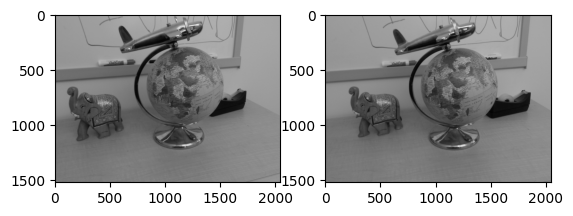

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

imgL_color = cv2.imread('globe1.jpg')
imgR_color = cv2.imread('globe2.jpg')

imgL_color = cv2.cvtColor(imgL_color, cv2.COLOR_BGR2RGB)
imgR_color = cv2.cvtColor(imgR_color, cv2.COLOR_BGR2RGB)

imgL = cv2.imread('globe1.jpg',cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('globe2.jpg',cv2.IMREAD_GRAYSCALE)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(imgL,cmap='gray')
axarr[1].imshow(imgR,cmap='gray');

We need the calibration to generate the essential matrix. We looked before at how to calibrate a camera, so we won't go through that again. Here, we just use the calibration.

In [3]:
# The calibration is the same for both images, as they were captured using the same camera.

# First two are radial distortion, second two are tangential, which we ignore (set to zero)
dist = np.array([0.138220594989358, -0.291158084324502, 0, 0])

# The projection matrix.
K_init = np.array([[1901.61685419446, 0               , 1051.33708372959],
                   [0               , 1894.94457228005, 778.616424720309],
                   [0               , 0               , 1               ]])

h, w = imgL.shape[:2]


It's not obvious form the images above, but there is a slight radial distortion. We want to work with undistorted images (it makes our life a little easier). So, here, we undistort before the feature extraction.

(2048, 1520)
(16, 13, 2020, 1496)


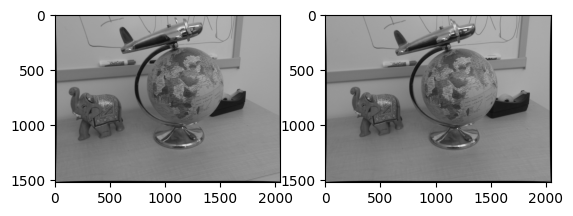

In [4]:
# We're going to use OpenCV to do this.
# When you undistort, we change the camera matrix slightly. OpenCV provides a hady function that updates this.
K_new, roi = cv2.getOptimalNewCameraMatrix(K_init, dist, (w,h), 1, (w,h))

# Now we will undistort the image pair
imgL = cv2.undistort(imgL, K_init, dist, None, K_new)
imgR = cv2.undistort(imgR, K_init, dist, None, K_new)

# we will just store the new camera matrix
K = K_new

# plot
f, axarr = plt.subplots(1,2)
axarr[0].imshow(imgL,cmap='gray')
axarr[1].imshow(imgR,cmap='gray');

print((w,h))
print(roi)

You can see that the undistortion above is very slight. There is a slight curvature outward of the image. It is slight, but it does exist, so it is good to remove it. Let's now get rid of the black areas.

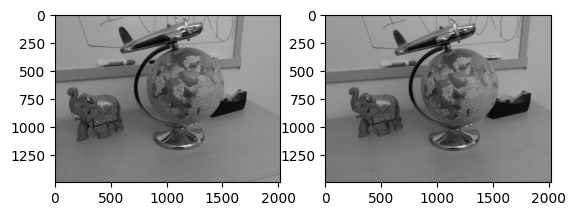

In [5]:
# crop the image.
# Usefully, getOptimalNewCameraMatrix returns an roi that defines the area of the image without the black bits.
# Crop using np.array slicing
x, y, w, h = roi
imgL = imgL[y:y+h, x:x+w]
imgR = imgR[y:y+h, x:x+w]

# plot
f, axarr = plt.subplots(1,2)
axarr[0].imshow(imgL,cmap='gray')
axarr[1].imshow(imgR,cmap='gray');

In previous vision modules, you will have covered feature matching. I don't expect you to repeat that here. So I will give you the code to match the two images using ORB. And we will match the features between the frames.

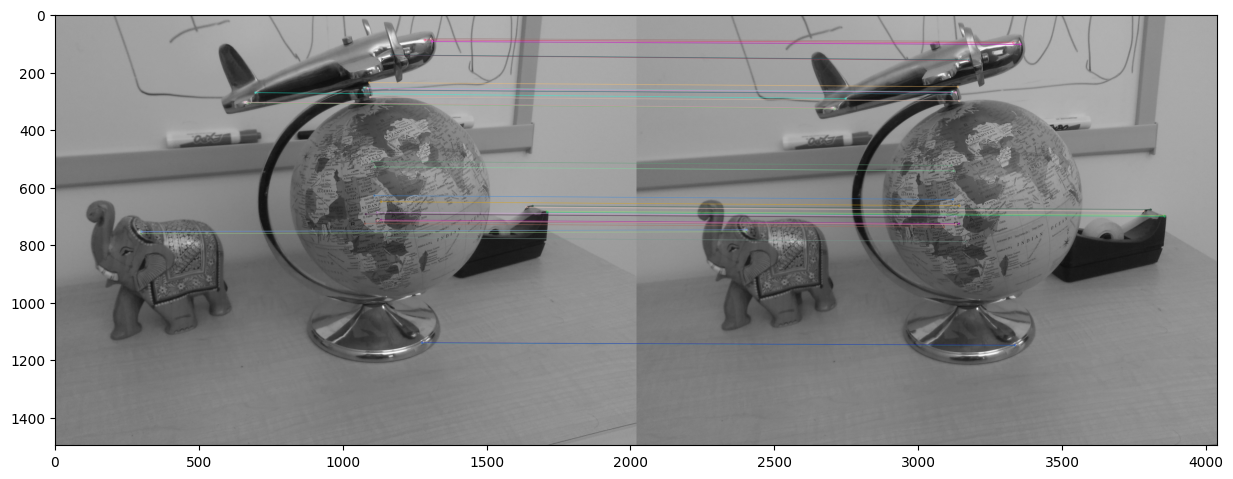

In [6]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(imgL,None)
kp2, des2 = orb.detectAndCompute(imgR,None)
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

N_PTS = 40

img3 = cv2.drawMatches(imgL,kp1,imgR,kp2,matches[:N_PTS],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15)),plt.imshow(img3),plt.show();

left_pts = np.float32([kp1[m.queryIdx].pt for m in matches[:N_PTS]]).reshape(-1,2)
rght_pts = np.float32([kp2[m.trainIdx].pt for m in matches[:N_PTS]]).reshape(-1,2)

## Estimate the Essential Matrix

Now, let's get into your code.

We're going to estimate the essential matrix by using the DLT (again!). This is called the 8-point algorithm (as it requires a minimum of 8 points.

![image.png](attachment:image.png)

Step 1, we already have.

<font color='blue'>
    
#### Task
    
Complete the rest of the 8-point algorithm, steps 2 to 5. Refer to lecture 5.14 for the details on estimating the essential matrix.

<font color='blue'>

##### Step 2: normalise the image points
The essential matrix assumes normalised image coordinate (though, the 8-point algorithm works on non-normalised image coordinates, but returns the fundamental matrix). Take a look at Lecture 4.12 for how to get the normalise image coordinates.
    
![image-2.png](attachment:image-2.png)
    
Note, however, you can skip the last undistortion step. We have already undistorted out image above, so we don't need to do that step here. (just do steps 1 and 2).
    
Remember, the result should be a set of homogeneous coordinates (so append with a 1)

In [7]:
def normalize_points(points, K):
    """
    Normalize image coordinates by converting to homogeneous coordinates and applying inverse camera matrix.
    """
    points_h = np.column_stack((rght_pts, np.ones(rght_pts.shape[0])))
    points_h = np.hstack([points, np.ones((points.shape[0], 1))])  # Convert to homogeneous coordinates
    points_n = (np.linalg.inv(K) @ points_h.T).T  # Normalize using the inverse of K
    return points_n[:, :]

# Normalize points
left_pts_n = normalize_points(left_pts, K)
right_pts_n = normalize_points(rght_pts, K)

<font color='blue'>

##### Steps 3 to 5:
    
At the end of these steps, print the essential matrix rank (Google to find the numpy function to use). At this point, the rank should b 3.

In [8]:
def construct_matrix_A(left_pts, right_pts):
    """
    Construct the A matrix for the 8-point algorithm.
    """
    A = []
    for i in range(left_pts.shape[0]):
        x, y, _ = left_pts[i]
        x_prime, y_prime, _ = right_pts[i]
        A.append([x * x_prime, x * y_prime, x, y * x_prime, y * y_prime, y, x_prime, y_prime, 1])
    return np.array(A)

def estimate_essential_matrix(A):
    """
    Estimate the essential matrix using SVD.
    """
    _, _, Vt = np.linalg.svd(A, full_matrices=True)
    E = Vt[-1].reshape(3, 3)  # Last column of V reshaped into a 3x3 matrix
    return E

# Construct the A matrix
A = construct_matrix_A(left_pts_n, right_pts_n)

# Estimate the essential matrix
E = estimate_essential_matrix(A)
print(E)
print("Rank of initial Essential Matrix:", np.linalg.matrix_rank(E))

[[ 0.02018841  0.06549612  0.08977323]
 [ 0.0297811  -0.00996335  0.69346069]
 [-0.07450081 -0.70697071  0.00340462]]
Rank of initial Essential Matrix: 3


<font color='blue'>

##### Step 6: Enforce the rank-2 contstraint.
    
![image.png](attachment:image.png)
    
Print the rank of the new essential matrix to make sure it worked.

In [9]:
print(E)

[[ 0.02018841  0.06549612  0.08977323]
 [ 0.0297811  -0.00996335  0.69346069]
 [-0.07450081 -0.70697071  0.00340462]]


In [10]:
np.linalg.matrix_rank(E)

3

In [11]:
def enforce_rank2_constraint(E):
    """
    Enforce the rank-2 constraint on the essential matrix.
    """
    U, S, Vt = np.linalg.svd(E, full_matrices=True)
    print(S)
    S[-1] = 0  # Set the smallest singular value to zero
    E_rank2 = U @ np.diag(S) @ Vt  # Recompute E with enforced rank-2 constraint
    return E_rank2

# Enforce the rank-2 constraint
E_rank2 = enforce_rank2_constraint(E)
print("Rank of Essential Matrix after enforcing rank-2 constraint:", np.linalg.matrix_rank(E_rank2))

print("Estimated Essential Matrix:")
print(E_rank2)

[0.71413144 0.69995246 0.00910191]
Rank of Essential Matrix after enforcing rank-2 constraint: 2
Estimated Essential Matrix:
[[ 0.01126381  0.06644953  0.0901854 ]
 [ 0.03094609 -0.0100878   0.69340688]
 [-0.07535638 -0.70687931  0.00344413]]


Excellent, you have successfully estimated the essential matrix for this image pair!





## Draw some points and epipolar lines

To visualise the essential matrix, there is probably no better way than to draw a set of epipolar lines. So this is what we are going to do. but it's worth having a little discussion first about how to go about this.

Recall that if we have a point in the left image $\mathbf{x}$, we get the parameters of the line, i.e. $l' = \mathbf{Ex}$. $l'$ is represented by a 3-vector, i.e. $l' = (s, t, u)^\top$. However, these parameters are in the normalised image coordinates, and we need to convert to the pixel coordinates. How to do this?

Let's call $\mathbf{x}_{img} \leftrightarrow \mathbf{x'}_{img}$ our pixel coordinate, and $\mathbf{x} \leftrightarrow \mathbf{x'}$ the corresponding ideal coordinate, for a given match.

We note that the epipolar constraint is $\mathbf{x'}^\top\mathbf{Ex} = 0$, and that the epipolar line in the right image is $l' = \mathbf{Ex}$. Thus we get the constraint $\mathbf{x'}^\top l' = 0$, by simple substution. This describes that the point $\mathbf{x'}$ lies on the epipolar line $l'$. This is all in normalised image coordinates.

Recall, to move a point from normalised image coordinates to pixel image coordinates, we multiply by the camera intrinsics matrix $\mathbf{K}$, i.e., $\mathbf{x}_{img} = \mathbf{Kx}$, or, conversely, $\mathbf{x} = \mathbf{K}^{-1}\mathbf{x}_{img}$. Then we get the relation, $(\mathbf{K}^{-1}\mathbf{x'}_{img})^\top l' = 0$. By the property of the distribution of transposes, we get $\mathbf{x'}_{img}^\top \mathbf{K}^{-\top} l' = 0$.

This is still a point-line relation. We can say that the normalised point $\mathbf{x'}_{img}^\top \mathbf{K}^{-\top}$ lies on the normalised homogeneous line $l'$, or we can say the image point $\mathbf{x'}_{img}$ lies on the image line $\mathbf{K}^{-\top} l'$.

All of this is a long way of showing that the image (pixel) line coordinates is $l'_{img} = \mathbf{K}^{-\top} l'$, and the relationship $ \mathbf{x'}_{img}^{\top} l'_{img} = 0$.

The elements of the line are $l'_{img} = (s'_{img}, t'_{img}, u'_{img})$. Thus, we get $s'_{img}x'_{img} + t'_{img}y'_{img} + v'_{img} = 0$.




<font color='blue'>
    
**Task:** Pick a handful of the features, draw the features (in both images), and draw the corresponding epipolar lines in the right hand image. Plot the resulting image pair.
    
Notes:
* To get the epipolar line in the right normalised image, multiply the left ideal/normalised point by the essential matrix $l' = \mathbf{Ex}$
* To get the line in pixel coordinates, do $l'_{img} = \mathbf{K}^{-\top} l'$
* To draw the features (in the left and right images), use [`cv2.circle`](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#gaf10604b069374903dbd0f0488cb43670)
* Use the opencv function [`cv2.line`](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga7078a9fae8c7e7d13d24dac2520ae4a2) to draw the epipolar line
* To draw the line, you need two points on the line, but we have a homogeneous equation $s'_{img}x'_{img} + t'_{img}y'_{img} + v'_{img} = 0$. Get one point by, for example, setting $x'_{img}$ to zero and solving for $y'_{img}$. Similarly, you can set $x'_{img}$ to the image width and solve for $y'_{img}$ again. This will give you two points for the line.
    
No need to do this for all the points - the drawing would be a mess. Just do it for a handfull of points.

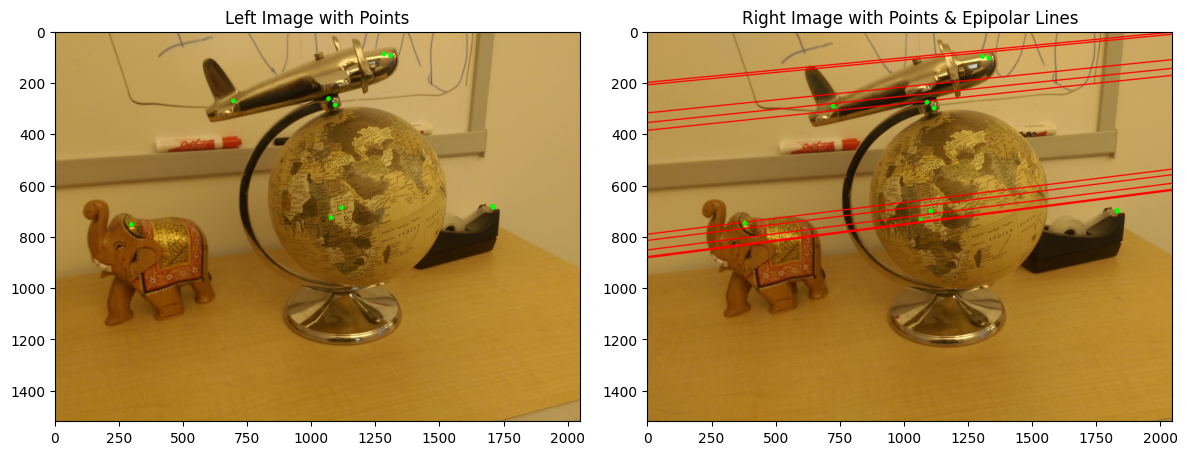

In [43]:
def display_epipolar_lines(left_img, right_img, left_points, right_points, E, K):

  # For simplicity just take 10 pts
  num_points = 10

  for i in range(num_points):
    # Destructure left and right points
    current_left_point, current_right_point = left_points[i], right_points[i]

    # Homogenize
    current_left_point_homogenous = np.array([current_left_point[0], current_left_point[1], 1.0])

    # Normalize
    current_left_point_normailized = np.linalg.inv(K) @ current_left_point_homogenous

    # To get the epipolar line in the right normalised image, multiply the left ideal/normalised point by the essential matrix l′=Ex
    l_n = E.dot(current_left_point_normailized)

    # To get the line in pixel coordinates, do l′img=K−⊤l′
    l_img = np.linalg.inv(K).T.dot(l_n)

    a, b, c = l_img[0], l_img[1], l_img[2]

    # Right image width and height
    h, w = right_img.shape[:2]

    # Get line coordinates
    if (b != 0):
      [x0, y0] = [int(-c / a) if (a != 0) else 0, 0]
      [x1, y1] = [int(-(c + b*(h-1)) / a) if (a != 0) else w-1, h-1]
    else:
      x0 = x1 = int(-c / a)
      y0 = 0
      y1 = h-1

    # Use the opencv function cv2.line to draw the epipolar line
    cv2.line(right_img, (x0, y0), (x1, y1), (255, 0, 0), 4)
    cv2.circle(left_img,  (int(current_left_point[0]), int(current_left_point[1])), 5, (0, 255, 0), 8)
    cv2.circle(right_img, (int(current_right_point[0]), int(current_right_point[1])), 5, (0, 255, 0), 8)

  # Plot
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(left_img)
  plt.title("Left Image with Points")

  plt.subplot(1, 2, 2)
  plt.imshow(right_img)
  plt.title("Right Image with Points & Epipolar Lines")

  plt.tight_layout()
  plt.show()


# Draw epipolar lines
display_epipolar_lines(imgL_color, imgR_color, left_pts, rght_pts, E_rank2, K)

**Commentary**: when I implemented this, it worked OK, but definitely wasn't perfect. My epipolar lines didn't always intersect with their corresponding features, again due to the DLT not being robust. We're going to move on and do a robust homography estimation. But, lucky for you, we'll use OpenCV (we probably had enough of implementing our own RANSAC algorithm from the last e-tivity).

<font color='blue'>

# Questions

<font color='blue'>

**Question**: Discuss the importance of the rank(2) constraint on the essential matrix estimation (hint: Lecture 5.14)

The rank-2 constraint on the essential matrix is crucial because it ensures that the estimated matrix corresponds to a valid rigid-body transformation between two camera views. Without enforcing this constraint, the essential matrix may not accurately describe the geometric relationship between the two views, leading to incorrect epipolar constraints. The singular value decomposition (SVD) allows us to impose this constraint by setting the smallest singular value to zero, ensuring that the essential matrix represents a valid motion with only two degrees of freedom.

<font color='blue'>

**Question**: Describe what *you* see when *you* draw the epipolar lines. How does it look?

! Double click to add text

When drawing the epipolar lines, they appear as straight lines across the right image that correspond to the selected feature points in the left image. Ideally, each epipolar line should pass through the correct corresponding point in the right image. However, due to noise, errors in feature matching, and limitations of the 8-point algorithm, some lines may not align perfectly with their corresponding points. This imperfection highlights the need for robust estimation techniques like RANSAC to improve accuracy.

<font color='blue'>
   
**Question**: How would you go about finding the epipolar lines in left image?

To find the epipolar lines in the left image, we follow a similar approach to how we found them in the right image. Given a feature point in the right image, we multiply it by the transpose of the essential matrix to obtain the corresponding epipolar line in the left image. This gives a homogeneous line equation, which we then convert into pixel coordinates using the inverse transpose of the camera matrix. Finally, we can draw the line by computing its intersection with the image borders and visualizing it accordingly.

<font color='blue'>

**Question**: You may need a bit of a web search to answer this one. In both the homography estimation and the essential matrix estimation, we took the result column of $\mathbf{V}$ that corresponded to the smallest singular value to be our estimate (i.e., the right most column). But why the smallest singular value?

The smallest singular value is used in both homography and essential matrix estimation because it represents the least significant component of the transformation. In the context of SVD, the rightmost column of V (corresponding to the smallest singular value) defines the solution that minimizes the least-squares error. Since these problems involve solving an overdetermined system of linear equations, minimizing the smallest singular value ensures that the solution best satisfies the constraints while reducing the impact of noise and numerical instability.